In [1]:
!pip install d2l==0.16.3


     |████████████████████████████████| 81kB 6.3MB/s 


# 1.Implementation of Recurrent Neural Networks from Scratch



In [2]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


In [4]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## One-Hot Encoding



In [5]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [6]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

## Initializing the Model Parameters

In [7]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

## RNN Model

To define an RNN model,
we first need an `init_rnn_state` function
to return the hidden state at initialization.
It returns a tensor filled with 0 and with a shape of (batch size, number of hidden units).
Using tuples makes it easier to handle situations where the hidden state contains multiple variables,
which we will encounter in later sections.


In [8]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [9]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

With all the needed functions being defined,
next we create a class to wrap these functions and store parameters for an RNN model implemented from scratch.


In [10]:
class RNNModelScratch:
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

Let us check whether the outputs have the correct shapes, e.g., to ensure that the dimensionality of the hidden state remains unchanged.


In [11]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))




## Prediction



In [12]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [13]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller kdubgzmixi'

## Gradient Clipping




In [14]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## Training




In [15]:

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

The training function supports
an RNN model implemented
either from scratch
or using high-level APIs.


In [16]:

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

Now we can train the RNN model.
Since we only use 10000 tokens in the dataset, the model needs more epochs to converge better.


perplexity 1.0, 121762.7 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


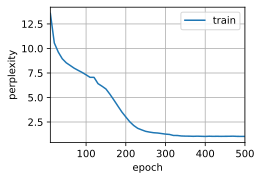

In [17]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

Finally,
let us check the results of using the random sampling method.


perplexity 1.6, 119364.1 tokens/sec on cuda:0
time travellerit sougirentre he hone a gone a venseow allw the t
travellerit s against reason said filby of course a solid b


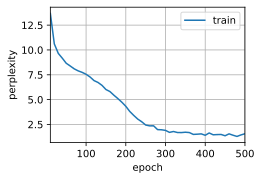

In [18]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

# 2.LSTM Networks

In [19]:
#Import the libraries
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [20]:
features = (np.random.randint(10, size=(100, 1)))
print(features.shape)

(100, 1)


In [21]:
training_dataset_length = math.ceil(len(features) * .75)
print(training_dataset_length)

75


In [22]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(features)

In [23]:
train_data = scaled_data[0:training_dataset_length  , : ]

#Splitting the data
x_train=[]
y_train = []

for i in range(10, len(train_data)):
    x_train.append(train_data[i-10:i,0])
    y_train.append(train_data[i,0])

In [24]:
#Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into 3-D array
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [25]:
from keras.layers import Dropout

# Initialising the RNN
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and Dropout layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and Dropout layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and and Dropout layer
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
# For Full connection layer we use dense
# As the output is 1D so we use unit=1
model.add(Dense(units = 1))

In [26]:
#compile and fit the model on 30 epochs
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 30, batch_size = 50)

Epoch 1/30
2/2 [==============================] - 36s 17ms/step - loss: 0.2636
Epoch 2/30
2/2 [==============================] - 0s 10ms/step - loss: 0.2196
Epoch 3/30
2/2 [==============================] - 0s 10ms/step - loss: 0.1714
Epoch 4/30
2/2 [==============================] - 0s 10ms/step - loss: 0.1262
Epoch 5/30
2/2 [==============================] - 0s 10ms/step - loss: 0.0882
Epoch 6/30
2/2 [==============================] - 0s 10ms/step - loss: 0.1200
Epoch 7/30
2/2 [==============================] - 0s 10ms/step - loss: 0.1044
Epoch 8/30
2/2 [==============================] - 0s 10ms/step - loss: 0.0933
Epoch 9/30
2/2 [==============================] - 0s 10ms/step - loss: 0.0939
Epoch 10/30
2/2 [==============================] - 0s 10ms/step - loss: 0.0997
Epoch 11/30
2/2 [==============================] - 0s 10ms/step - loss: 0.1056
Epoch 12/30
2/2 [==============================] - 0s 10ms/step - loss: 0.1109
Epoch 13/30
2/2 [==============================] - 0s 10ms/s

In [27]:
#Test data set
test_data = scaled_data[training_dataset_length - 10: , : ]

#splitting the x_test and y_test data sets
x_test = []
y_test =  features[training_dataset_length : , : ] 

for i in range(10,len(test_data)):
    x_test.append(test_data[i-10:i,0])
    
#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into 3-D array
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [28]:
#check predicted values
predictions = model.predict(x_test) 
#Undo scaling
predictions = scaler.inverse_transform(predictions)

#Calculate RMSE score
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

2.8420301493018187